# Load Images

## Compare hrHSI and Snapshot

### Load HrHSI

In [ ]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/corn_m3"
hr_mtx_path = 'calibration/hrHSI_matrix.npy'
hr_dist_path = 'calibration/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
# Preview hrHSI
from preprocessing import previewHrHSI
previewHrHSI(hr_img, hr_wavelengths, 
             selected_pixel=(500, 500),
             selected_spectrum=200)

### Load Snapshot

In [ ]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/processed/train/corn_m3/"
ss_mtx_path = 'calibration/snapshot_matrix.npy'
ss_dist_path = 'calibration/snapshot_dist.npy'
ss_x_off = (0, 405)
ss_y_off = (0, 214)

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path, ss_x_off, ss_y_off)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
# Preview snapshot
from preprocessing import previewSnapshot
previewSnapshot(ss_img, ss_wavelengths, 
                 selected_pixel=(100, 150),
                 selected_spectrum=12)

ss_img.shape

### Compare images

In [ ]:
from align_images import align_images, plot_image_comparison

# Set offsets and rotations
hr_x_off = (106, 1018)   # Full: (0, 1084) # Previous: (104, 1019)
hr_y_off = (189, 720)   # Full: (0, 1015) # Previous: (189, 720)
rot = -0.2
shear = 0.017
# rot = 0
# shear = 0

ss_x_off = (3, 402)
ss_y_off = (2, 212)


# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    ss_x_off=ss_x_off,
                                    ss_y_off=ss_y_off,
                                    hr_x_off=hr_x_off, 
                                    hr_y_off=hr_y_off,
                                    rot=rot,
                                    shear=shear)




# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(115, 220),
                      selected_spectrum=715)

## Compare aspect ratios

In [ ]:
# Compare resolutions
print("HrHSI:", hr_img_al.shape)
print("Shapshot:", ss_img_al.shape)
print("\n")

# Compare aspect ratio
print("HrHSI:", round(hr_img_al.shape[1] / hr_img_al.shape[0], 6))
print("Shapshot:", round(ss_img_al.shape[1] / ss_img_al.shape[0], 6))

# Difference between aspect ratios
print("Difference:", round((hr_img_al.shape[1] / hr_img_al.shape[0]) - (ss_img_al.shape[1] / ss_img_al.shape[0]), 6))

# Compare Fully Processed Images

### Load hrHSI and go through full preprocessing pipeline

In [ ]:
from preprocessing import preprocessFullHSI
import matplotlib.pyplot as plt

# Specify paths
hr_path = 'data/FX10/spelt_s3.hdf5'
hr_mtx_path = 'calibration/hrHSI_matrix.npy'
hr_dist_path = 'calibration/hrHSI_dist.npy'

# Snapshot dimensions and wavelengths
# ss_shape = (210, 399, 24)
ss_shape = (210, 210, 24) # Square
ss_wavelengths = [667, 679, 691, 703, 715, 
                  727, 739, 751, 763, 775, 
                  787, 799, 811, 823, 835, 
                  847, 859, 871, 883, 895, 
                  907, 919, 931, 943]


# Set offsets and rotations
# hr_x_off = (106, 1018)   # Full: (0, 1084)
# hr_y_off = (189, 720)    # Full: (0, 1015)
hr_x_off = (110, 590)   # Square
hr_y_off = (191, 719)   # Square
rot = -0.3
shear = 0.02
# rot = -0.2
# shear = 0.017

# Load and preprocess file
hr_file = preprocessFullHSI(path_to_hdf5=hr_path, 
                            mtx_path=hr_mtx_path, 
                            dist_path=hr_dist_path, 
                            hr_x_off=hr_x_off, 
                            hr_y_off=hr_y_off, 
                            rot=rot, 
                            shear=shear, 
                            ss_shape=ss_shape, 
                            ss_wavelengths=ss_wavelengths)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

# Display image
plt.imshow(hr_img[:, :, 3])
plt.show()

print(hr_img.shape)

### Load snapshot

In [ ]:
from preprocessing import preprocessSnapshot
import matplotlib.pyplot as plt

# Specify paths
ss_path = "data/Snapshot/processed/train/spelt_s3/"
ss_mtx_path = 'calibration/snapshot_matrix.npy'
ss_dist_path = 'calibration/snapshot_dist.npy'

# Load and preprocess file
# ss_x_off = (3, 402)
# ss_y_off = (2, 212)
ss_x_off = (3, 213)
ss_y_off = (2, 212)

ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path, ss_x_off, ss_y_off)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]


plt.imshow(ss_img[:, :, 3])
plt.show()

print(ss_img.shape)

### Show side by side comparison

In [ ]:
from align_images import plot_image_comparison

# Plot image comparison
plot_image_comparison(hr_img=hr_img, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(100, 100),
                      selected_spectrum=800)

In [ ]:
print(ss_img.shape)
print(hr_img.shape)

# Print aspect ratio
print("HrHSI:", round(hr_img.shape[1] / hr_img.shape[0], 6))
print("Shapshot:", round(ss_img.shape[1] / ss_img.shape[0], 6))

# Compare fully-processed files

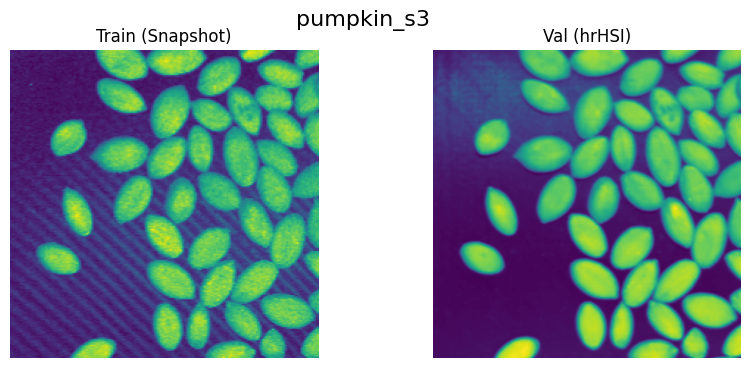

Train: 1.0
Val: 1.0
Train: (210, 210, 24)
Val: (480, 480, 24)


In [3]:
import numpy as np

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]

# Select image
image_id = "pumpkin_s3"

train_img = np.load("data/processed/full_hsi/lr/" + image_id + ".npy")
val_img = np.load("data/processed/full_hsi/hr/" + image_id + ".npy")


# Plot images next to each other
import matplotlib.pyplot as plt

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# plt.tight_layout()
fig.suptitle(image_id, fontsize=16)
axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(train_img[:, :, 10])
axs[1].imshow(val_img[:, :, 10])
axs[0].set_title("Train (Snapshot)")
axs[1].set_title("Val (hrHSI)")
plt.show()

# Print aspect ratios
print("Train:", round(train_img.shape[1] / train_img.shape[0], 6))
print("Val:", round(val_img.shape[1] / val_img.shape[0], 6))

# Print shapes
print("Train:", train_img.shape)
print("Val:", val_img.shape)

In [114]:
# print(val_img)
print(train_img.shape)

(480, 480)


In [43]:
import cv2 as cv
import numpy as np
import os

def npy_to_rgb(input_folder, target_folder):

    # List all images in the folder
    inputs = os.listdir(input_folder)
    print(inputs)

    for file_name in inputs:
        # Read the image using OpenCV
        image = np.load(input_folder + file_name)
        
        # Select only 3 channels
        rgb_array = image[:, :, [0, 12, 23]] * 255

        # Save the npy file in target folder
        # np.save(target_folder + file_name.split('/')[-1][:-4] + ".npy", rgb_array)

        # Save the image as a jpg file
        cv.imwrite(target_folder + file_name.split('/')[-1][:-4] + ".jpg", rgb_array)


# Example usage
# input_folder = "data/processed/bicubic_480/"
input_folder = "data/processed/full_hsi/bi_240/"
# target_folder = "data/processed/rgb_array/bi_480/"
target_folder = "data/processed/rgb_array/bi_240_jpg/"
rgb_array = npy_to_rgb(input_folder, target_folder)

['sunflower_l1.npy', 'flax_m1.npy', 'corn_s3.npy', 'millet_s3.npy', 'wheatgrass_s2.npy', 'barley_m3.npy', 'spelt_m4.npy', 'corn_s1.npy', 'spelt_m1.npy', 'barley_m0.npy', 'wheatgrass_l4.npy', 'buckwheat_l2.npy', 'flaxb_l3.npy', 'barley_s1.npy', 'sunflower_s0.npy', 'flaxb_s3.npy', 'millet_l4.npy', 'rye_m1.npy', 'buckwheat_m1.npy', 'sunflower_l3.npy', 'spelt_m3.npy', 'sunflower_m3.npy', 'wheatgrass_s0.npy', 'flax_s4.npy', 'flaxb_m1.npy', 'mix_m4.npy', 'mix_l1.npy', 'flax_s2.npy', 'mix_s1.npy', 'spelt_l2.npy', 'spelt_s2.npy', 'pumpkin_l4.npy', 'millet_l3.npy', 'rye_m4.npy', 'sunflower_s1.npy', 'pumpkin_m0.npy', 'flaxb_s1.npy', 'spelt_l4.npy', 'sunflower_m1.npy', 'wheatgrass_m3.npy', 'millet_m4.npy', 'pumpkin_s4.npy', 'flax_l1.npy', 'mix_s4.npy', 'wheatgrass_m4.npy', 'sunflower_l2.npy', 'mix_s3.npy', 'millet_l1.npy', 'spelt_l1.npy', 'corn_m0.npy', 'rye_l4.npy', 'pumpkin_l0.npy', 'barley_s3.npy', 'pumpkin_l2.npy', 'buckwheat_m2.npy', 'rye_l0.npy', 'spelt_s0.npy', 'mix_l2.npy', 'flax_m3.npy',

# Loop over all images to check for corruption

In [ ]:
import numpy as np
import cv2 as cv

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]
densities = ["s", "m", "l"]
img_nos = [0, 1, 2, 3, 4]


for f in grains:
    for d in densities:
        for i in img_nos:
            image_id = f + "_" + d + str(i)
            train_img = np.load("data/Processed/train/" + image_id + ".npy")
            val_img = np.load("data/Processed/val/" + image_id + ".npy")
            bicubic_img = np.load("data/Processed/bicubic_480/" + image_id + ".npy")
            cv.imwrite("data/Processed/images/train/" + image_id + ".jpg", train_img[:, :, 10] * 255)
            cv.imwrite("data/Processed/images/val/" + image_id + ".jpg", val_img[:, :, 10] * 255)
            cv.imwrite("data/Processed/images/bicubic_480/" + image_id + ".jpg", bicubic_img[:, :, 10] * 255)

In [ ]:
# Load processed training image
train_img = np.load("data/Processed/train/corn_m3.npy")
print("train: ", train_img.shape)

# Load processed validation image
val_img = np.load("data/Processed/val/barley_m3.npy")
print("val: ", val_img.shape)

# Load processed bicubic image
bicubic_img = np.load("data/Processed/bicubic/barley_m3.npy")
print("bicubic: ", bicubic_img.shape)

In [ ]:
print(train_img.min())

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2 as cv

class PairedDataset(Dataset):
    def __init__(self, train_folder, val_folder, transform=None):
        self.train_folder = train_folder
        self.val_folder = val_folder
        self.transform = transform
        self.train_files = sorted(os.listdir(train_folder))
        self.val_files = sorted(os.listdir(val_folder))
        self.paired_files = [(train_file, val_file) for train_file, val_file in zip(self.train_files, self.val_files) if train_file == val_file]

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        train_file, val_file = self.paired_files[idx]
        train_image = np.load(os.path.join(self.train_folder, train_file))
        val_image = np.load(os.path.join(self.val_folder, val_file))
        
        # Interpolate train image to (480, 912, 24)
        train_image = cv.resize(train_image, (912, 480), interpolation=cv.INTER_LINEAR)

        # Make both images square (480, 480)
        train_image = train_image[:, 216:696]
        val_image = val_image[:, 216:696]
        
        
        if self.transform:
            train_image = self.transform(train_image)
            val_image = self.transform(val_image)
        
        return train_image, val_image

# Paths to training and validation images
train_folder = "data/Processed/train"
val_folder = "data/Processed/val"

# Example usage
paired_dataset = PairedDataset(train_folder, val_folder)
# paired_loader = DataLoader(paired_dataset, batch_size=4, shuffle=True)
loader = DataLoader(paired_dataset, batch_size=4, shuffle = True, drop_last = True, num_workers = 2)

# Display two images next to each other
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.tight_layout()

axs[0].imshow(loader.dataset[38][0][:, :, 10])
axs[1].imshow(loader.dataset[38][1][:, :, 10])
axs[0].set_title("Train (Snapshot)")
axs[1].set_title("Val (hrHSI)")
plt.show()


# .npy Image Viewer

In [183]:
import numpy as np
from ipywidgets import interact, IntSlider

import matplotlib.pyplot as plt

def view_two_npy_images(hr_path, sr_path, channel=0):
    # Load the images
    image1 = np.load(hr_path)
    image2 = np.load(sr_path)
    
    # Normalize the images to scale [0, 1]
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    
    # Display the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(image1[:, :, channel], vmin=0, vmax=1)
    axs[0].set_title(f'HR Image - Channel: {channel}')
    axs[0].axis('off')
    
    axs[1].imshow(image2[:, :, channel], vmin=0, vmax=1)
    axs[1].set_title(f'SR Image - Channel: {channel}')
    axs[1].axis('off')
    
    plt.show()

# Example usage
# hr_path = "results/HSI_x2_50000/hr/pumpkin_m4.npy"
# sr_path = "results/HSI_x2_50000/sr/pumpkin_m4.npy"
hr_path = "data/processed/full_hsi/hr/pumpkin_l3.npy"
sr_path = "data/processed/full_hsi/synth_240/pumpkin_l3.npy"
interact(view_two_npy_images, hr_path=hr_path, sr_path=sr_path, channel=IntSlider(min=0, max=23, step=1, value=0))

interactive(children=(Text(value='data/processed/full_hsi/hr/pumpkin_l3.npy', description='hr_path'), Text(val…

<function __main__.view_two_npy_images(hr_path, sr_path, channel=0)>

In [203]:
import cv2 as cv

# Example usage
# image_path = "Real-ESRGAN/inputs/pumpkin_m4.npy"
# image_path = "results/sr/pumpkin_m4.npy"
image_path = "data/processed/full_hsi/test/synth_240/barley_s4.npy"
image = np.load(image_path)

print(image.shape)
print(type(image))

print(image.max())
print(image.min())

(240, 240, 24)
<class 'numpy.ndarray'>
1.0
0.0


In [6]:
import numpy as np
import os
import random

# Load all .npy files in the folder
folder_path = "data/processed/full_hsi/hr/"
npy_file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.npy')]


sum_values = None
count = 0

# Iterate through the random files and accumulate sum and count
for npy_file in npy_file_list:
	data = np.load(npy_file)
	if sum_values is None:
		sum_values = np.zeros(data.shape[-1])
	sum_values += np.sum(data, axis=(0, 1))
	count += data.shape[0] * data.shape[1]

# Calculate the mean and sd for each channel
mean_values = sum_values / count


# Initialize sum of squares
sum_squares = np.zeros(data.shape[-1])

# Iterate through the files again to calculate sum of squares
for npy_file in npy_file_list:
    data = np.load(npy_file)
    sum_squares += np.sum((data - mean_values) ** 2, axis=(0, 1))

# Calculate standard deviation
sd_values = np.sqrt(sum_squares / count)



print("Mean values for each channel:", np.round(mean_values, 3))
print("Standard deviation for each channel:", np.round(sd_values, 3))

Mean values for each channel: [0.35  0.369 0.393 0.422 0.44  0.453 0.468 0.474 0.491 0.497 0.507 0.515
 0.522 0.53  0.535 0.54  0.545 0.546 0.546 0.545 0.54  0.537 0.54  0.542]
Standard deviation for each channel: [0.171 0.171 0.172 0.176 0.181 0.184 0.188 0.188 0.191 0.192 0.194 0.196
 0.197 0.199 0.2   0.201 0.203 0.203 0.202 0.202 0.2   0.198 0.2   0.201]
